In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm
import os, sys
from PIL import Image
import gc
import time
import math
import numpy as np
import numpy.ma as ma
import matplotlib
from scipy.stats import lognorm
from astropy.io import fits
from scipy.stats import mode
import time
import ast
import matplotlib.pyplot as plt
import math
import fnmatch as fnm
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.signal import find_peaks
from scipy.io import readsav
import csv
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import LimbSpectralTool_getL1CData_v20 as gsi_l1c
import LimbSpectralTool_InteractiveTool_DN_v20 as spectralTool
from matplotlib.widgets import TextBox
import matplotlib.patches as patches
from collections import OrderedDict
from scipy import interpolate
import matplotlib.image as image
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from scipy import stats
import warnings
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

In [2]:
version = 'v20'

In [3]:
#Directory where magnetic field map ('bfield_smoothed.npy') and spectral templates are stored ('templates_.....npy')
map_and_data_dir = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps'

#Directory where npy files for clicked pixels are stored:
clicked_pixel_dir = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\pixel_npy_files' 

#Directory where L1C files are stored
dir_to_dataFiles = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\l1c_files'

In [4]:
#load a list of files for a specific observation type, i.e. periapse, inlimb, outlimb, etc

fileType = 'mvn' #this will load all files regardless of observation type
Range = (1600, 8700) #Use this to only load files with orbits within a specific region. 
                   #otherwise leave it as is to load files for the whole MAVEN mission length

orbits, l1cFiles = gsi_l1c.getFiles(fileType, dir_to_dataFiles, Range)

In [5]:
def run(orbN, scan):
    orbInd = np.where(orbits == orbN)[0][0]
    file = l1cFiles[orbInd]
    wave, orb, radCO, radUVD, radNO, spectra, COProfiles, UVDProfiles, NOProfiles, \
                alts, lats, lons, PAs, SZAs, LTs, fitIndices = gsi_l1c.getFileData(file)
    %matplotlib qt
    orbInd = 0
    
    coIndex, uvdIndex, noIndex = fitIndices[0], fitIndices[1], fitIndices[2]
    coImg = radCO[orbInd][scan, :, :] #CO scan image
    uvdImg = radUVD[orbInd][scan, :, :] #UVD scan image
    latC = lats[orbInd][scan, :, :, :]
    lonC = lons[orbInd][scan, :, :, :]
    spectrum = spectra[orbInd][scan, :, :, :]
    altProfileCO = COProfiles[orbInd][scan, :] #CO emission  altitude profile
    altProfileUVD = UVDProfiles[orbInd][scan, :] #UVD emission  altitude profile
    altProfileNO = NOProfiles[orbInd][scan, :] #NO emission  altitude profile
    alt = alts[orbInd][scan, :]
    LT = LTs[orbInd][scan, :, :]
    wav = wave[orbInd][scan, 0, :]
    COaltProf_kR = np.nanmean(fits.open(file)[4].data['PROFILE'][scan, :, coIndex])  #intensity of altitude fits
    UVDaltProf_kR = np.nanmean(fits.open(file)[4].data['PROFILE'][scan, :, uvdIndex]) 
    NOaltProf_kR = np.nanmean(fits.open(file)[4].data['PROFILE'][scan, :, noIndex]) 
    
    spectralTool.runSpectralTool(file, wav, coImg, uvdImg, spectrum, altProfileCO, altProfileUVD, altProfileNO, alt, latC, lonC, LT, orbN, scan, version)

the main run cell is below.  enter orbit and scan and the tool will load. when finished, close the pop-up tool window and then enter the next orbit and scan you'd like to analyze.

In [16]:
%matplotlib qt
run(8676, 4)

In [10]:
#Grabs all .csv files printed out from using the spectral tool
pixelDataFiles = gsi_l1c.find_all('*limb_analysis_{}_orbit_*'.format(version), clicked_pixel_dir)

In [9]:
len(pixelDataFiles)

24

In [9]:
files, recordedOrbits, recordedScans, wave_kR, wave_DN, spectra_kR, spectra_DN, lons, lats, lonErrs, latErrs, pixels, LTs,\
            COintensity, UVDintensity, COmlr, UVDmlr = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
for i in range(len(pixelDataFiles)):
    data = np.load(pixelDataFiles[i], allow_pickle=True)

    orbit, scan = int(np.array(data[12])[0]), int(np.array(data[12])[1]) # orbit and scan of interest
    wavArr_kR = np.array(data[0], dtype=np.float64) # wavelength values #nm
    wavArr_DN = np.array(data[1], dtype=np.float64) # wavelength values #nm
    spectrum_kR = np.array(data[2], dtype=np.float64) # spectrum values of clicked pixels, kR/nm
    spectrum_DN = np.array(data[3], dtype=np.float64) # spectrum values of clicked pixels, DN/nm
    lon = np.array(data[4], dtype=np.float64) # center longitudes of clicked pixels, degrees
    lat = np.array(data[5], dtype=np.float64) # center latitudes of clicked pixels, degrees
    lonErr = np.array(data[6], dtype=np.float64) # error values for centers of clicked longitudes, degrees
    latErr = np.array(data[7], dtype=np.float64) # error values for centers of clicked latitudes, degrees
    pix = np.array(data[8]) # pixels clicked, first is the integration (y-axis), secoond is the row (x axis)
    lt = np.array(data[9], dtype=np.float64) # local times of clicked pixels
    mlrCOval = np.array(data[10], dtype=np.float64) #intensity (MLR) values of clicked pixels
    mlrUVDval = np.array(data[11], dtype=np.float64) #intensity (MLR) values of clicked pixels
        
    

    recordedOrbits.append(orbit)
    recordedScans.append(scan)
    wave_kR.append(wavArr_kR)
    spectra_kR.append(spectrum_kR)
    wave_DN.append(wavArr_DN)
    spectra_DN.append(spectrum_DN)
    lons.append(lon)
    lats.append(lat)
    lonErrs.append(lonErr)
    latErrs.append(latErr)
    pixels.append(pix)
    LTs.append(lt)
    COmlr.append(mlrCOval)
    UVDmlr.append(mlrUVDval)
    COintensity.append(np.round(np.mean(mlrCOval), 2))
    UVDintensity.append(np.round(np.mean(mlrUVDval), 2))
    files.append(data[13])

    #print(f"file: {pixelDataFiles[i]}")
    #print(f"CO MLR values for clicked pixels: {mlrCOval}")
    #print(f"UVD MLR values for clicked pixels: {mlrUVDval}")
    #print('\n\n')

files = np.array(files)
recordedOrbits = np.array(recordedOrbits)
recordedScans = np.array(recordedScans)
wave_kR = np.array(wave_kR)
spectra_kR = np.array(spectra_kR)
wave_DN = np.array(wave_DN)
spectra_DN = np.array(spectra_DN)
lons = np.array(lons)
lats = np.array(lats)
lonErrs = np.array(lonErrs)
latErrs = np.array(latErrs)
pixels = np.array(pixels)
LTs = np.array(LTs)
COmlr = np.array(COmlr)
UVDmlr = np.array(UVDmlr)
COintensity = np.array(COintensity)
UVDintensity = np.array(UVDintensity)

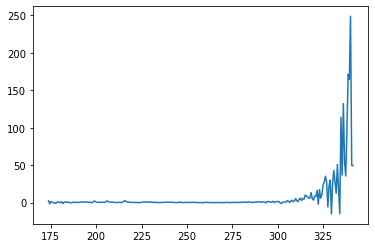

In [10]:
%matplotlib inline
plt.plot(wave_kR[0], spectra_kR[0])

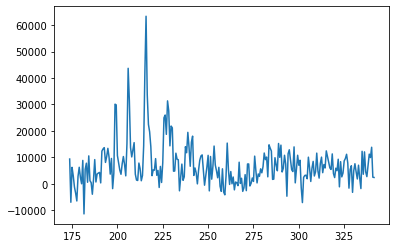

In [11]:
plt.plot(wave_DN[0], spectra_DN[0])